In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_lag_n = pd.read_csv("../../data/processed/pagos_por_unidad.csv",
                  dtype = {
                                "unidad_id": "object",
                            },
                  parse_dates = ["expensa_mes_pago"])

In [15]:
data = pd.read_csv("../../data/processed/expensas_full_processed_vis.csv",
                  dtype = {
                                "expensa_id": "object",
                                "unidad_id": "object",
                                "consorcio_id": "object",
                                "expensa_mes":"object",
                            },
                  parse_dates = ["expensa_fecha", "expensa_mes_pago", "expensa_mes_pago_anterior"])

In [16]:
data.dtypes

expensa_id                                      object
consorcio_id                                    object
consorcio_nombre                                object
consorcio_cantidad_expensas                    float64
consorcio_prop_impagos                         float64
consorcio_prop_efectivo                        float64
unidad_id                                       object
unidad_denominacion                             object
unidad_tipo                                     object
expensa_proporcion                             float64
expensa_interes_primer_vencimiento             float64
expensa_ineteres_segundo_vencimiento           float64
expensa_mes                                     object
expensa_fecha                           datetime64[ns]
expensa_mes_pago                        datetime64[ns]
pago_metodo                                     object
target                                         float64
expensa_mes_pago_anterior               datetime64[ns]
dtype: obj

In [17]:
data.shape

(214812, 18)

In [5]:
final_data = pd.merge(
    data[["expensa_id", "unidad_id", "unidad_tipo", "expensa_mes", "expensa_mes_pago"]],
    data_lag_n,
    left_on = ["unidad_id", "expensa_mes_pago"],
    right_on = ["unidad_id", "expensa_mes_pago"],
    how = "inner"
)

In [6]:
final_data.shape

(168955, 12)

In [7]:
data_lag_n.shape

(168955, 9)

In [8]:
final_data.columns

Index(['expensa_id', 'unidad_id', 'unidad_tipo', 'expensa_mes',
       'expensa_mes_pago', 'pago_metodo_lag_6', 'pago_metodo_lag_5',
       'pago_metodo_lag_4', 'pago_metodo_lag_3', 'pago_metodo_lag_2',
       'pago_metodo_lag_1', 'target'],
      dtype='object')

In [47]:
model_columns = ['unidad_tipo', 'expensa_mes', 'pago_metodo_lag_6', 'pago_metodo_lag_5',
       'pago_metodo_lag_4', 'pago_metodo_lag_3', 'pago_metodo_lag_2',
       'pago_metodo_lag_1'] 
model_columns = ['unidad_tipo', 'expensa_mes', 'pago_metodo_lag_3', 'pago_metodo_lag_2',
       'pago_metodo_lag_1'] 

final_data = final_data.sort_values("expensa_mes_pago").reset_index().drop(columns="index")
min_cv_id = final_data.loc[final_data.expensa_mes_pago == "2018-06-01", "expensa_mes_pago"].idxmin()
min_test_id = final_data.loc[final_data.expensa_mes_pago == "2018-09-01", "expensa_mes_pago"].idxmin()

In [48]:
def get_train_test_split(X_columns):
    X_train = pd.get_dummies(final_data.loc[0:min_test_id, X_columns])
    X_test = pd.get_dummies(final_data.loc[min_test_id:, X_columns])
    Y_train = final_data.loc[0:min_test_id, "target"]
    Y_test = final_data.loc[min_test_id:, "target"]
    
    X_train = X_train[['unidad_tipo_Casa', 'unidad_tipo_Cochera',
       'unidad_tipo_Departamento', 'unidad_tipo_Duplex', 'unidad_tipo_Local',
       'unidad_tipo_Lote', 'unidad_tipo_Oficina',
       'expensa_mes_02', 'expensa_mes_03', 'expensa_mes_04', 'expensa_mes_05',
       'expensa_mes_06', 'expensa_mes_07', 'expensa_mes_08', 'expensa_mes_09',
       'expensa_mes_10', 'expensa_mes_11', 'expensa_mes_12',
       'pago_metodo_lag_3_Efec-Cheque', 'pago_metodo_lag_3_EntePago',
       'pago_metodo_lag_3_Impago', 'pago_metodo_lag_3_Internet',
       'pago_metodo_lag_2_Efec-Cheque',
       'pago_metodo_lag_2_EntePago', 'pago_metodo_lag_2_Impago',
       'pago_metodo_lag_2_Internet',
       'pago_metodo_lag_1_Efec-Cheque', 'pago_metodo_lag_1_EntePago',
       'pago_metodo_lag_1_Impago', 'pago_metodo_lag_1_Internet',
       'pago_metodo_lag_1_Otro']]
    
    drop_test_columns = [column for column in X_test.columns if column not in X_train.columns]
    X_test = X_test.drop(columns=drop_test_columns)

    for column in [column for column in X_train.columns if column not in X_test.columns]:
        X_test[column] = 0
    
    X_test = X_test[X_train.columns]
    print(X_train.shape, Y_train.shape)
    print(X_test.shape, Y_test.shape)
    return X_train, Y_train, X_test, Y_test

In [49]:
X_train, Y_train, X_test, Y_test = get_train_test_split( model_columns )

(131848, 31) (131848,)
(37108, 31) (37108,)


In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def get_train_test_meassures(model, X_train, Y_train, X_test, Y_test):
    train_preds = model.predict(X_train)
    print("accuracy:", accuracy_score(Y_train, train_preds))
    print("precision:", precision_score(Y_train, train_preds))
    print("recall:", recall_score(Y_train, train_preds))
    print("f1:", f1_score(Y_train, train_preds))
    print("--------------------------------------------------")
    test_preds = model.predict(X_test)
    print("accuracy:", accuracy_score(Y_test, test_preds))
    print("precision:", precision_score(Y_test, test_preds))
    print("recall:", recall_score(Y_test, test_preds))
    print("f1:", f1_score(Y_test, test_preds))

In [51]:
def get_logReg_coef(model, columns):
    lm_coef = pd.DataFrame({
        "variable": columns,
        "coef": model.coef_[0]
    })

    lm_coef["abs_coef"] = abs(lm_coef.coef)

    from pandas.api.types import CategoricalDtype
    lm_coef = lm_coef.sort_values("abs_coef", ascending = False)
    lm_coef = lm_coef.reset_index().drop(columns="index")

    variable_cat = CategoricalDtype(categories=lm_coef.variable, ordered=True)
    lm_coef.variable = lm_coef.variable.astype(variable_cat)

    figure_size = (16, 4.8)
    return (ggplot(data=lm_coef)
        + geom_bar(aes(x = "variable",y="coef"), stat = "identity", fill = "#5DADE2")
        + theme(
            axis_text_x = element_text(angle = 45, hjust = 1),
            figure_size = (16, 4.5),
            panel_background = element_rect(fill = "white"),
            panel_grid = element_line(color="grey", linetype="dashed", size=0.5)
        )
        + ggtitle("Coeficientes de Analisis Discriminante Lineal")
        + ylab("Valor del Coeficiente")
        + xlab("Variable")
    )

## Regresion Logistica

In [68]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

param_grid = {
    "solver": ["svd", "lsqr", "eigen"],
    "shrinkage": [None, "auto"]
}

lda = GridSearchCV(
    estimator = LinearDiscriminantAnalysis(),
    param_grid = param_grid,
    scoring = 'f1',
    n_jobs = -1,
    cv = [(list(range(0,min_cv_id)), list(range(min_cv_id,min_test_id)))],
    return_train_score = True,
    error_score = 0,
    verbose = 5
)
lda.fit(X_train.values, Y_train.values)

Fitting 1 folds for each of 6 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.6s finished
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  wa

GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, ...4, 131835, 131836, 131837, 131838, 131839, 131840, 131841, 131842, 131843, 131844, 131845, 131846])],
       error_score=0,
       estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'solver': ['svd', 'lsqr', 'eigen'], 'shrinkage': [None, 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=5)

In [70]:
get_train_test_meassures(lda, X_train, Y_train, X_test, Y_test)

accuracy: 0.8742794733329289
precision: 0.7793732922504506
recall: 0.7489803899659199
f1: 0.7638746438746438
--------------------------------------------------
accuracy: 0.8787054004527326
precision: 0.7561588738059326
recall: 0.7014107496793751
f1: 0.7277566079961291


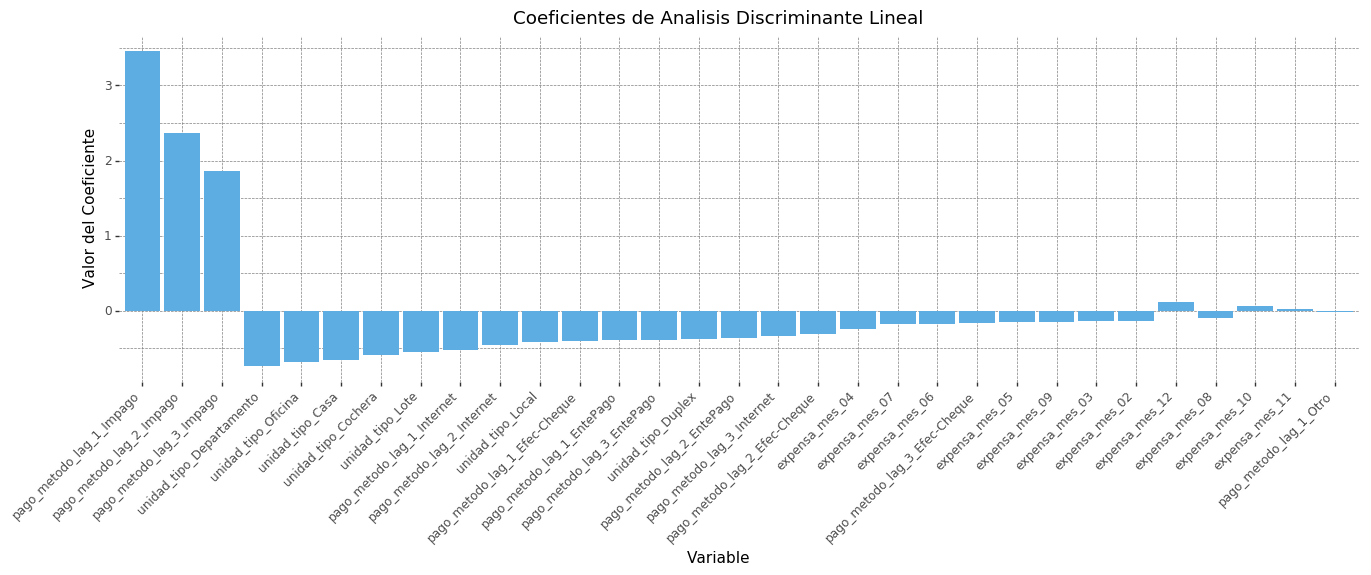

<ggplot: (132929046932)>

In [69]:
get_logReg_coef(lda.best_estimator_, X_train.columns)

In [55]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Real',
           xlabel='Predicho')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[26591  1940]
 [ 2561  6016]]


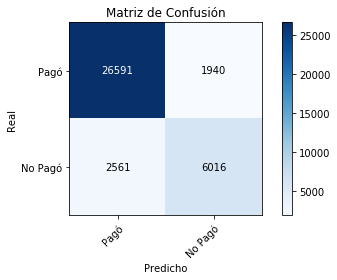

In [71]:
test_preds = lda.predict(X_test)
plot_confusion_matrix(Y_test, test_preds, ["Pagó", "No Pagó"], title= "Matriz de Confusión")

In [72]:
data_test = final_data.loc[min_test_id:,:]
data_test["Prediccion"] = test_preds

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [73]:
falsos_positivos = data_test.loc[data_test.Prediccion & ~data_test.target,["pago_metodo_lag_3","pago_metodo_lag_2","pago_metodo_lag_1", "target"]].groupby(["pago_metodo_lag_3","pago_metodo_lag_2","pago_metodo_lag_1"]).count()
falsos_positivos = falsos_positivos.reset_index()
falsos_positivos.columns = ["Método de pago 3 meses atrás","Método de Pago 2 meses atrás", "Método de pago mes anterior", "Cantidad de Falsos Positivos"]
falsos_positivos.sort_values("Cantidad de Falsos Positivos", ascending=False)

,Método de pago 3 meses atrás,Método de Pago 2 meses atrás,Método de pago mes anterior,Cantidad de Falsos Positivos
8,Impago,Impago,Impago,637
7,Impago,Impago,EntePago,227
5,Impago,EntePago,Impago,208
6,Impago,Impago,Efec-Cheque,173
1,Efec-Cheque,Impago,Impago,166
3,EntePago,Impago,Impago,147
4,Impago,Efec-Cheque,Impago,125
9,Impago,Impago,Internet,104
13,Internet,Impago,Impago,74
11,Impago,Internet,Impago,66


In [80]:
falsos_positivos = data_test.loc[data_test.Prediccion & ~data_test.target,["pago_metodo_lag_3","pago_metodo_lag_2","pago_metodo_lag_1", "target"]]
falsos_positivos.loc[falsos_positivos.pago_metodo_lag_3 != "Impago", "pago_metodo_lag_3"] = "Pago"
falsos_positivos.loc[falsos_positivos.pago_metodo_lag_2 != "Impago", "pago_metodo_lag_2"] = "Pago"
falsos_positivos.loc[falsos_positivos.pago_metodo_lag_1 != "Impago", "pago_metodo_lag_1"] = "Pago"
falsos_positivos = falsos_positivos.groupby(["pago_metodo_lag_3","pago_metodo_lag_2","pago_metodo_lag_1"]).count().reset_index()
falsos_positivos.columns = ["Método de pago 3 meses atrás","Método de Pago 2 meses atrás", "Método de pago mes anterior", "Cantidad de Falsos Positivos"]
falsos_positivos.sort_values("Cantidad de Falsos Positivos", ascending=False)

,Método de pago 3 meses atrás,Método de Pago 2 meses atrás,Método de pago mes anterior,Cantidad de Falsos Positivos
0,Impago,Impago,Impago,637
1,Impago,Impago,Pago,506
2,Impago,Pago,Impago,400
3,Pago,Impago,Impago,392
4,Pago,Pago,Impago,5


In [79]:
falsos_negativos = data_test.loc[~data_test.Prediccion & data_test.target,["pago_metodo_lag_3","pago_metodo_lag_2","pago_metodo_lag_1", "target"]]
falsos_negativos.loc[falsos_negativos.pago_metodo_lag_3 != "Impago", "pago_metodo_lag_3"] = "Pago"
falsos_negativos.loc[falsos_negativos.pago_metodo_lag_2 != "Impago", "pago_metodo_lag_2"] = "Pago"
falsos_negativos.loc[falsos_negativos.pago_metodo_lag_1 != "Impago", "pago_metodo_lag_1"] = "Pago"
falsos_negativos = falsos_negativos.groupby(["pago_metodo_lag_3","pago_metodo_lag_2","pago_metodo_lag_1"]).count()
falsos_negativos = falsos_negativos.reset_index()
falsos_negativos = falsos_negativos.sort_values("target", ascending=False)
falsos_negativos.loc[falsos_negativos.pago_metodo_lag_3 != "Impago", "pago_metodo_lag_3"] = "Pago"
falsos_negativos.loc[falsos_negativos.pago_metodo_lag_2 != "Impago", "pago_metodo_lag_2"] = "Pago"
falsos_negativos.loc[falsos_negativos.pago_metodo_lag_1 != "Impago", "pago_metodo_lag_1"] = "Pago"
falsos_negativos.columns = ["Método de pago 3 meses atrás","Método de Pago 2 meses atrás", "Método de pago mes anterior", "Cantidad de Falsos Negativos"]
falsos_negativos

,Método de pago 3 meses atrás,Método de Pago 2 meses atrás,Método de pago mes anterior,Cantidad de Falsos Negativos
4,Pago,Pago,Pago,1260
3,Pago,Pago,Impago,484
2,Pago,Impago,Pago,424
1,Impago,Pago,Pago,383
0,Impago,Impago,Pago,10


In [12]:
target_prop = final_data.target.mean()

In [13]:
base_plot = (ggplot(data, aes(fill='factor(target)'))
 + geom_hline(yintercept=target_prop) 
 + ylab("Proporcion de Pagos Tardios")
 + scale_fill_manual(["#5DADE2", "#EC7063"], name="Paga Tarde") 
 + theme(
     panel_background = element_rect(fill = "white"),
     panel_grid = element_line(color="grey", linetype="dashed", size=0.5)
 )
)

def get_xlab(varname):
    varname = varname.split("_")
    varname = varname[1:]
    varname = " ".join(varname)
    return varname.capitalize()

def get_title(varname):
    varname = varname.replace("_", " ")
    varname = varname.capitalize()
    varname += " vs Target"
    return varname

def plot_target_vs_var(varname, xlab_rot = 0):
    return (base_plot 
            + geom_bar(aes(x=varname),position = "fill")
            + geom_hline(yintercept=target_prop, linetype="dashed")
            + xlab(get_xlab(varname))
            + ggtitle(get_title(varname))
            + theme(axis_text_x = element_text(angle = xlab_rot, hjust = 1)))

def plot_cat_var(varname, xlab_rot = 0):
    return (base_plot 
            + geom_bar(aes(x=varname))
            + xlab(get_xlab(varname))
            + ggtitle(get_xlab(varname))
            + theme(axis_text_x = element_text(angle = xlab_rot, hjust = 1)))

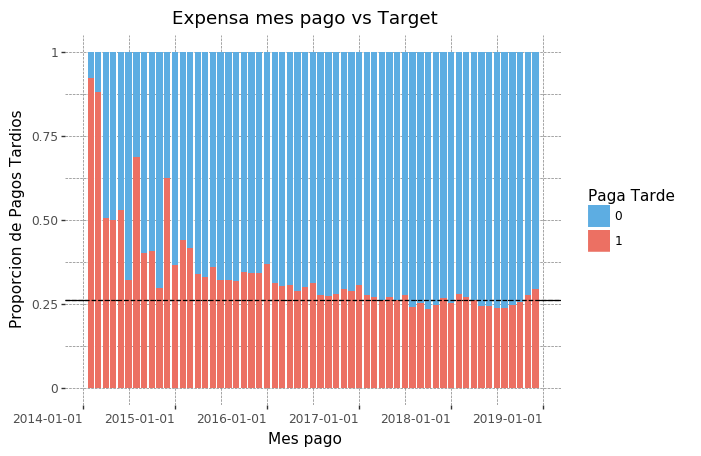

<ggplot: (-9223371882873775279)>

In [14]:
plot_target_vs_var("expensa_mes_pago")